# Scikit-Learn Pipelines for churn

This notebook accompanies [this blog post](http://philipmgoddard.com/modeling/sklearn_pipelines) to demonstrate the usage of machine learning pipelines using Scikit-Learn. The churn dataset from the R C.50 package is used as an example.

I use [conda](https://conda.io/docs/index.html) to manage my Python environments: you can use environment.yml to rebuild my environment. 

__This contains updates, where I demonstrate how to use a factory method and mixins to incorporate sampling methods into your pipelines.__

In [67]:
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# imports for piplelines
from sklearn.pipeline import Pipeline, FeatureUnion

# built-in transformer which we will use in our pipelines
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

#evaluation metrics  
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve

# models and model selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# custom imports
from custom_transformers import DataFrameSelector, NullsColRemoval, ZeroVariance, OptionalSimpleImputer
from custom_transformers import FindCorrelation, OptionalStandardScaler, CategoricalEncoder 
from custom_transformers import  OptionalPowerTransformer, OptionalPCA, PipelineChecker
from ml_plot import kde_plot, hist_plot, cat_plot, pairwise_plot, LiftChart, ROCPlot, train_plot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Churn data with pipelines

We will be working with the churn dataset from the R C.50 package. 

In [68]:
# load into dataframe
churnTrain = pd.read_csv('churnTrain.csv')
churnTest = pd.read_csv('churnTest.csv')

# split features and outcome, and transform outcome to binary
features = [x for x in churnTrain if x != 'churn']
features_train = churnTrain[features]
features_test = churnTest[features]
outcome_train = churnTrain.loc[:, 'churn'].apply(lambda x: 1 if x == "yes" else 0)
outcome_test = churnTest.loc[:, 'churn'].apply(lambda x: 1 if x == "yes" else 0)

In [69]:
print('{} \n\nunique dtypes: {}'.format(features_train.info(),
                                        set([features_train[x].dtype for x in features_train])))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          3333 non-null   object 
 1   account_length                 3333 non-null   int64  
 2   area_code                      3333 non-null   object 
 3   international_plan             3333 non-null   object 
 4   voice_mail_plan                3333 non-null   object 
 5   number_vmail_messages          3333 non-null   int64  
 6   total_day_minutes              3333 non-null   float64
 7   total_day_calls                3333 non-null   int64  
 8   total_day_charge               3333 non-null   float64
 9   total_eve_minutes              3333 non-null   float64
 10  total_eve_calls                3333 non-null   int64  
 11  total_eve_charge               3333 non-null   float64
 12  total_night_minutes            3333 non-null   f

## Identify numeric and categorical features, as they require different preprocessing steps

For instance, we need to one-hot encode categorical features to obtain numerical values that can be fed into sklearn models.

In [70]:
fac_cols = [x for x in features_train if features_train[x].dtype == np.dtype('O')]
float_cols = [x for x in features_train if features_train[x].dtype == np.dtype('float64')]
int_cols = [x for x in features_train if features_train[x].dtype == np.dtype('int64')]

# convert objects into pandas categorical type
# get a warning (suppressed here), but we are OK
features_train.loc[:, fac_cols] = features_train.loc[:, fac_cols].apply(pd.Categorical).copy(deep=True)
features_test.loc[:, fac_cols] = features_test.loc[:, fac_cols].apply(pd.Categorical).copy(deep=True)

/Users/theotsiftis/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


We have a concern here: what would happen if a categorical value appeared in the test set that was not encountered in the training set? It would be a disaster for the automated pipeline we are going to build.

We have to be very careful here. Here is a simple function (its expressive rather than efficient) to test whether we have any issues for this toy data set.

In [71]:
def category_checker(X_train, X_test, cat_col):
    allowed_values = dict()
    for col in cat_col:
        allowed_values[col] = X_train[col].values.categories
    
    warn = False
    for col in cat_col:
        tmp = X_test[col].values.categories
        for val in tmp.values.tolist():
            if val not in allowed_values[col].values.tolist():
                print('WARNING: new categorical level encountered:', col, val)
                warn = True
    
    if not warn:
        print('No problems detected')

# we see that there are no categories in the test set that do not appear 
# in the training set
category_checker(features_train, features_test, fac_cols)

No problems detected


## Data exploration

I have investigated the features in previous blog posts - see [here](https://github.com/philipmgoddard/pycaret_demo/blob/master/pycaret_churn.ipynb) for instance.
I will leave some code for you to run should you be interested

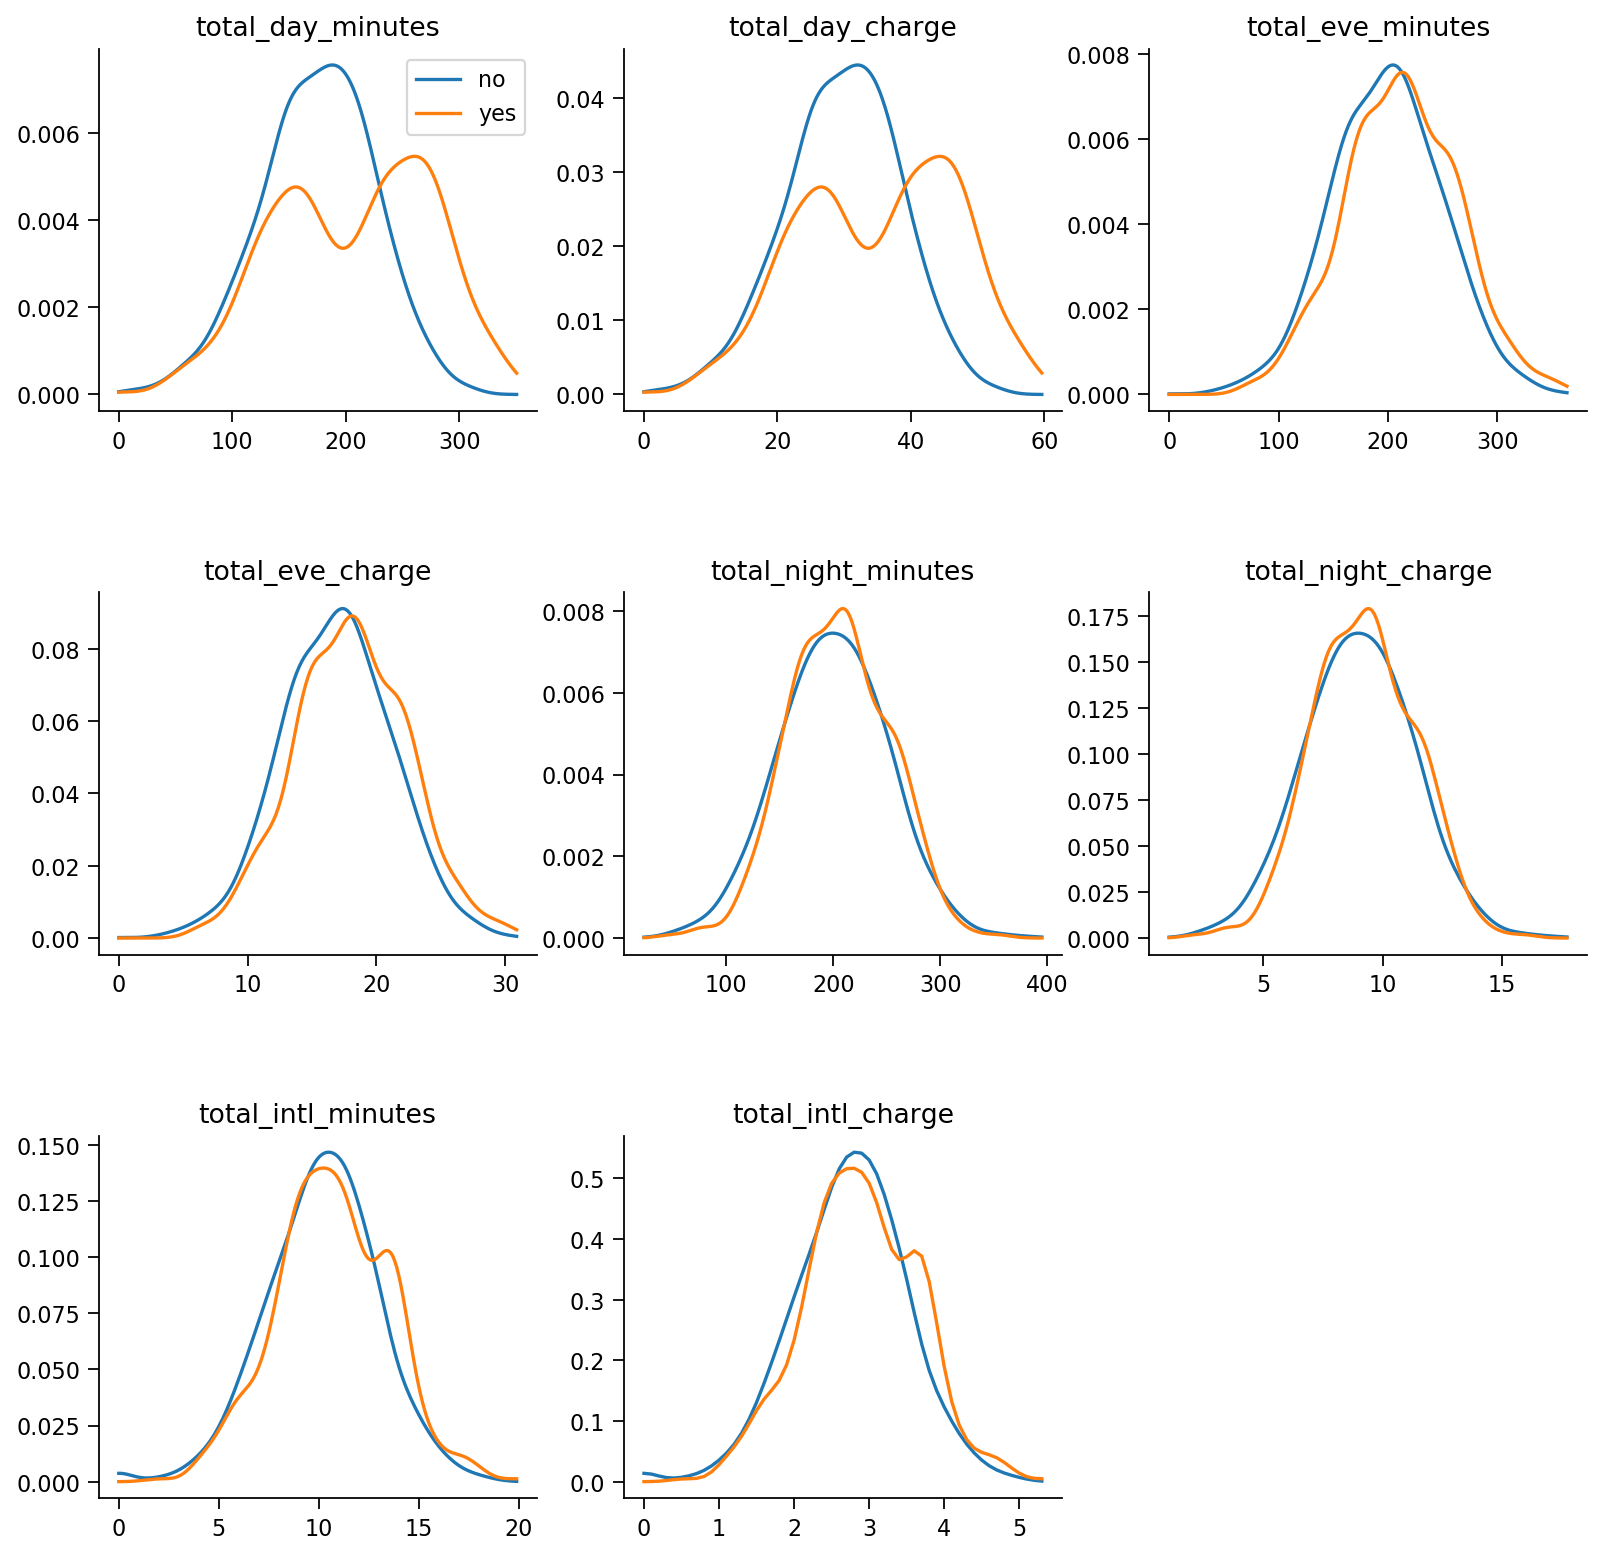

In [72]:
#-----------------------------------------------------------
#
# As an example, kernel density plots for numerical features.
#
#-----------------------------------------------------------

kde_plot(churnTrain.loc[:, float_cols  + ['churn']],
         outcome_col = 'churn',
         n_col = 3,
         plot_legend = True,
         f_size = (12,12));

In [73]:
#-----------------------------------------------------------
#
# Histograms for numerical features.
# Uncomment code below and run cell to produce.
# You may want to try hist_plot as well
#-----------------------------------------------------------

# hist_plot(churnTrain.loc[:, float_cols  + ['churn']],
#          outcome_col = 'churn',
#          n_col = 3,
#          plot_legend = True,
#          f_size = (12,12));

In [74]:
#-----------------------------------------------------------
#
# Bar charts for categorical features
# Uncomment code below and run cell to produce
#
#-----------------------------------------------------------

# cat_plot(churnTrain.loc[:, fac_cols + ['churn']],
#          outcome_col = 'churn',
#          n_col = 2,
#          plot_legend = True,
#          f_size = (22,12));

In [75]:
#-----------------------------------------------------------
#
# Pairwise plot to investigate correlations
# amongst numberical features (you may want to investigate)
# correlation between categorical features as well!)
# Uncomment code below and run cell to produce
#
#-----------------------------------------------------------

# pairwise_plot(churnTrain.loc[:, float_cols + int_cols + ['churn']],
#          outcome_col = 'churn',
#          f_size = (10,10));

## One hot encoding

I used to use pandas to do all my encoding before the pipeline, but it should be in the pipeline, as we 'learn' categories when we fit on the training data, and use this transform the test data.

The functionality in sklearn.preprocessing OneHotEncoder doesnt quite act as I would like. We have options to drop baseline categories. We __always__ want to do this when a field is binary (i.e. 2 categories) as they are fully correlated with one another. 

For some models, like linear models, where a field has more than 2 categories, we would drop one to ensure multicolinearity is not introduced. However, for other models, like trees, we actually lose information if we do this (the tree considers each feature in isolation at each split). The transformer in sklearn doesnt allow you to drop the baseline in some but not all categorical features. So, we will keep all, and then manually drop categories where appropriate.

What we need to do then is find the index of the encoded columns that we may want to remove.


In [76]:
# Need to drop: international_plan_no, voice_mail_plan_no as these are binary.
# Depending on model drop a class >n2 categories- trees need to keep, wheras linear models will consider a base class

# what are the column indices? Remember, sklearn uses numpy arrays,
# not pandas dataframes, so index by column index
fac_col_names = ["state", "area_code", "international_plan", "voice_mail_plan"]

# a little grubby now: determine how many levels in each category, to determine the index
n_levels = [features_train[x].unique().shape[0] for x in fac_col_names]

# get column indices to remove for all models (binary so fully correlated)
drop_col_ix = []
ix = 0
for l in n_levels:
    if l == 2:
        drop_col_ix.append(ix)
    ix += l

# column indices for models that wont be effected by baseline for n categories > 2 (e.g. trees)
opt_drop_col_ix = []
ix = 0
for l in n_levels:
    if ix not in drop_col_ix:
        opt_drop_col_ix.append(ix)
    ix += l

In [77]:
opt_drop_col_ix

[0, 51]

## Pipeline

Lets break down our pipeline into stages: in this case, we want to perform some feature selection (e.g. drop low variance features), data preprocessing (calculate polynomial features) before we fit an estimator (our learning algorithm).

We can consider seperate stages we want to perform for numerical and categorical features before we fit a model. Scikit Learn has a handy FeatureUnion class, which allows us to perform a stage of the pipeline in parrallel, and combine the results before we move on to the next step. 

Lets think what we want to do for the numerical and categorical features. We will later combine these using a feature union, as they should be performed in parrallel, not sequentially.

For numerical we want to:
- select numerical features from our input
- remove features with high percentage of null values
- remove zero variance features, and optionally low variance features
- impute missing values for features with not percentage of null values
- check for any correlations and remove if above a threshold
- scale the data (OptionalStandardScaler allows us to toggle this on or off)
- transform features to make them more Gaussian-like. 
- calculate polynomial features (interactions). This can be toggled as if degree = 1 it will just return original features
- construct uncorrelated features using PCA and perform feature selection

For categorical data we want to:
- select categorical features
- remove features with high percentage of null values
- impute missing values for features with not percentage of null values
- encode either as one hot encode or label, depending on the predictive algorithm to be used
- drop columns where the category was binary, as we know the two columns will be fully correlated. Also, we can optionally drop further columns, which may be useful for linear models if we want one level from each categegory to be the 'baseline'
- remove zero variance features, and optionally low variance features
- check for any correlations and remove if above a threshold

'selector', DataFrameSelector(fac_col_names)),
    ('nulls_col_removal', NullsColRemoval(threshold=0.3)),
    ('simple_imputer', OptionalSimpleImputer(SimpleImpute=True, strategy='most_frequent')),
    ('categorical_encoder', CategoricalEncoder(OneHot=True, drop_ix = drop_col_ix)),
    ('zero_var', ZeroVariance(near_zero=True)),
    ('correlation', FindCorrelation(threshold=0.9))])


Other than PolynomialFeatures, all the transformers are custom written. Feel free to use! :)

## Numerical Features Pipeline

In [78]:
# data pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(float_cols + int_cols)),
    ('nulls_col_removal', NullsColRemoval(threshold=0.3)),
    ('zero_var', ZeroVariance(near_zero=True)),
    ('simple_imputer', OptionalSimpleImputer(SimpleImpute=True)),
    ('correlation', FindCorrelation(threshold=0.9)),
    ('opt_scaler', OptionalStandardScaler(scale=False)),
    ('power_transformer', OptionalPowerTransformer(PowerTransform=False)),
    ('poly_features', PolynomialFeatures(degree=1, include_bias=False)),
    ('pca_transformer', OptionalPCA(PCATransform=True))])

num_arr = num_pipeline.fit_transform(features_train)

# step 1: those filtered by nulls column removal. Pass in the remaining names from the previous step
names_1 = num_pipeline.get_params()['nulls_col_removal'].get_feature_names(np.array(float_cols + int_cols))

# step 2: those filtered by zero variance
names_2 = num_pipeline.get_params()['zero_var'].get_feature_names(names_1)

# step 3: those filtered by correlation. Pass in the remaining names from the previous step
names_3 = num_pipeline.get_params()['correlation'].get_feature_names(names_2)

# and prove we have recovered names..
pd.DataFrame(num_arr, columns=names_3).head()

,total_day_charge,total_eve_charge,total_night_charge,total_intl_charge,account_length,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
0,27.256135,-10.827934,4.024453,-4.804567,-14.564398,0.311197,-1.685087,1.834621,-0.533959,0.045744
1,6.524843,-20.652189,-1.888566,9.366552,3.261548,0.360911,-1.654716,2.228371,-0.547656,-0.938812
2,36.389268,-12.028031,-9.433634,6.106490,-10.536660,6.701191,0.604432,-1.759574,-1.562060,-0.476977
3,-17.839436,25.569130,12.043556,-17.026929,-20.699330,12.066410,2.561380,-0.027923,0.415674,0.990980
4,-25.626364,-9.462625,-25.654352,18.604684,2.754264,4.401130,-1.441032,-0.862177,1.415144,0.023972


## Categorical Features Pipeline


In [79]:
# data pipeline for categorical features
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(fac_col_names)),
    ('nulls_col_removal', NullsColRemoval(threshold=0.3)),
    ('simple_imputer', OptionalSimpleImputer(SimpleImpute=True, strategy='most_frequent')),
    ('categorical_encoder', CategoricalEncoder(OneHot=True, drop_ix = drop_col_ix)),
    ('zero_var', ZeroVariance(near_zero=True)),
    ('correlation', FindCorrelation(threshold=0.9))])

# Same for categorical
cat_array = cat_pipeline.fit_transform(features_train)
names_1 = cat_pipeline.get_params()['nulls_col_removal'].get_feature_names(np.array(fac_col_names))
names_2 = cat_pipeline.get_params()['categorical_encoder'].get_feature_names(names_1)
names_3 = cat_pipeline.get_params()['zero_var'].get_feature_names(names_2)
names_4 = cat_pipeline.get_params()['correlation'].get_feature_names(names_3)

# and prove we have recovered names...
pd.DataFrame(cat_array, columns=names_4).head(10)

,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes
0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0
5,0.0,0.0,1.0,1.0,0.0
6,0.0,0.0,1.0,0.0,1.0
7,0.0,1.0,0.0,1.0,0.0
8,1.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,1.0,1.0


### Putting together the pipeline

We will create a FeatureUnion of the numerical and categorical pipeline. This ensures they run in parallel- if they ran sequentially the results of one would be the input of the next, which we certainly dont want!

Following the feature union of the numerical and categorical pipeline, we perform a final correlation check, and a basic pipeline check via the PipelineChecker. At present this only ensures the train and test feature array have the same number of columns, but I will extend in future to check values as well (e.g. for outliers that will cause the model to be extrapolating, and may be producing unreliable results).

This pipeline can be used as a template, and we can append a final estimator (i.e. learning algorithm) to the end, allowing us to examine different models in isolation. I have seen people use a bunch of estimators in the same pipeline (so the model chooses the best by CV criteria), but I prefer to have more control and study the models in isolation.

In [80]:
#-----------------------------------------------------------
#
# Use feature union to make a big pipeline
#
#-----------------------------------------------------------

prep_pipe = Pipeline([
        
    ('union', FeatureUnion(
        transformer_list = [
                    
            # pipeline to transform numeric features
            ('num_pipeline', num_pipeline),
                    
            # pipeline for categorical
            ('cat_pipeline', cat_pipeline),
        ],
                
        #other arguments for FeatureInion        
        n_jobs = 1,
        transformer_weights = None
    )),
        
    # final correlation check
    ('correlation', FindCorrelation(threshold=0.9)),
        
    # error checking
    ('checker', PipelineChecker()),
])


## Modelling

The main joy of pipelines is that we can treat the preprocessing steps as hyperparameters! Lets dig into a couple of examples to show why this is so useful

### Logistic regression

Firstly, we will consider a logistic regression. We know that this is a linear model, so a hyperparameter we want to consider is the degree of polynomial terms (1 or 2). Degree 1 corresponds to the original data. We need to be careful going higher than degree 2 as we will quickly start to overfit, or encounter problems when we have more features than rows.

For a linear model we want to scale the input features.OptionalStandardScaler is simply a wrapper around StandardScaler that allows the scaling to be toggled on or off (other models, like trees, dont need this step, and we want to reuse the pipeline). Also, we need to drop baseline categories for all categorical features, otherwise we will introduce multicolinearity.

Other than that, trial an l1 or l2 penalty, and several values of C to tune the logistic regression. In principle, I could investigate even more parameters, but the number of models you must train and evaluate blows up very quickly, especially with the 5-fold CV I am using.

In [81]:
# logistic regression. take a copy of the pipeline, and append an estimator to the end
lr_est = copy.deepcopy(prep_pipe)
lr_est.steps.append(('logistic_regression', LogisticRegression(random_state = 1234,  solver='liblinear')))


In [82]:
# set the hyperparameter grid. Good news: we can treat preprocessing steps as we would
# any other hyperparameter. Be careful though, as can easily blow up number of models 
# will be building (especially with CV as well)
lr_param_grid = dict(union__num_pipeline__opt_scaler__scale=[True],
                     union__num_pipeline__poly_features__degree=[1, 2],
                     union__cat_pipeline__categorical_encoder__optional_drop_ix=[opt_drop_col_ix],
                     union__num_pipeline__pca_transformer__PCATransform=[True, False],
                     logistic_regression__penalty=['l1', 'l2'],
                     logistic_regression__C=[0.01, 0.1, 1, 10])


We will use a GridSearchCV object to perform our grid search, using 5-fold CV. We will assess models with the ROC AUC. Here, I set n_jobs to 1 (as I expect linear models to fit quickly), but in principle this is an embarrasingly parallel problem, so I could use multiple threads.

In [83]:
# cross validation object
grid_search_lr = GridSearchCV(estimator=lr_est,
                              param_grid=lr_param_grid,
                              scoring='roc_auc',
                              n_jobs=1,
                              cv=5,
                              refit=True,
                              verbose=1)

grid_search_lr.fit(features_train, outcome_train);

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   24.5s finished


In [84]:
# GridSearchCV object has many useful attributes, for example:
print('Chosen params: {}\n\nTrain AUC score: {:0.3f}'.format(grid_search_lr.best_params_,
                                                        grid_search_lr.best_score_))

Chosen params: {'logistic_regression__C': 0.1, 'logistic_regression__penalty': 'l1', 'union__cat_pipeline__categorical_encoder__optional_drop_ix': [0, 51], 'union__num_pipeline__opt_scaler__scale': True, 'union__num_pipeline__pca_transformer__PCATransform': False, 'union__num_pipeline__poly_features__degree': 2}

Train AUC score: 0.880


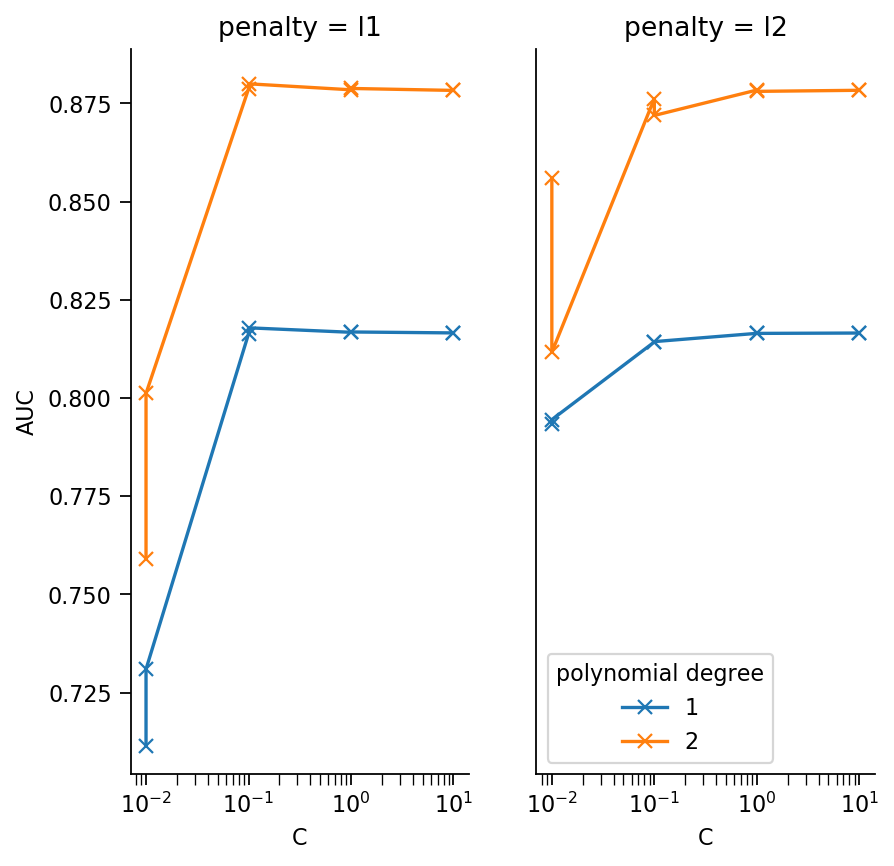

In [85]:
#-----------------------------------------------------------
#
# Visualise CV results
#
# Cannot look at everything, so we will consider the mean AUC of test folds 
# as a function of polynomial degree and penalty. 
#
#-----------------------------------------------------------

# results are stored as dict, lets pull into a dataframe
lr_results = pd.DataFrame(grid_search_lr.cv_results_)

plt_cols = ['param_logistic_regression__penalty',
            'param_union__num_pipeline__poly_features__degree',
            'param_logistic_regression__C',
            'mean_test_score',
            'std_test_score']

# filter and rename for neat plotting
lr_results = (lr_results
                 .loc[:, plt_cols]
                 .rename(columns = {'param_logistic_regression__C' : 'C',
                                    'param_logistic_regression__penalty': 'penalty',
                                    'param_union__num_pipeline__poly_features__degree' : 'polynomial degree',
                                    'mean_test_score' : 'AUC'
                                    })
)

# train plot is a plotting helper function for visualising hyperparameter training.
# it can consider up to three hyperparameters, and optionally can plot
# error bars. See ml_plots.py for the source code
train_plot(lr_results, logx=True);

### Aside: recovering feature names following the pipeline

We saw before that this can be done- lets apply same techniques to the full pipeline. Note that this is by design that this is possible- I added get_feature_names methods to all my custom transformers.

In [86]:
# rebuild features. Notice we selected polynomial degree 2 after cross validation,
# so we have lot of extra features

# can access parts of the CV pipeline object like so:
num_pipe_lr = grid_search_lr.best_estimator_.get_params()['union__num_pipeline']
cat_pipe_lr = grid_search_lr.best_estimator_.get_params()['union__cat_pipeline']

# names from numerical pipeline
names_1a = num_pipe_lr.get_params()['zero_var'].get_feature_names(np.array(float_cols + int_cols))
names_2a = num_pipe_lr.get_params()['correlation'].get_feature_names(names_1a)
names_3a = num_pipe_lr.get_params()['poly_features'].get_feature_names(names_2a)

# names from categorical pipeline
names_1b = cat_pipe_lr.get_params()['nulls_col_removal'].get_feature_names(np.array(fac_cols))
names_2b = cat_pipe_lr.get_params()['categorical_encoder'].get_feature_names(names_1b)
names_3b = cat_pipe_lr.get_params()['zero_var'].get_feature_names(names_2b)
names_4b = cat_pipe_lr.get_params()['correlation'].get_feature_names(names_3b)


# names following final correlation check
names_1c = np.array(names_3a + names_4b.tolist())
lr_feature_names = grid_search_lr.best_estimator_.get_params()['correlation'].get_feature_names(names_1c)

In [87]:
#-----------------------------------------------------------
#
# We can use this usefully: lets examine the coefficient of each 
# feature
#
#-----------------------------------------------------------

# coefficients are in the best_estimator_ attribute
lr_coef = grid_search_lr.best_estimator_.get_params()['logistic_regression'].coef_

# we can sort the list by coef, absolute coef etc. Display the top 10
sorted(list(zip( lr_coef[0], lr_feature_names )), key = lambda x: x[0], reverse=True)[:10]
#sorted(list(zip( lr_coef[0], lr_feature_names )), key = lambda x: abs(x[0], reversed=True))

[(1.9529624819628693, 'international_plan_yes'),
 (0.6408032956548464, 'total_day_charge'),
 (0.5324599370036582, 'number_customer_service_calls'),
 (0.3861324110732328, 'total_day_charge^2'),
 (0.36159509024250674, 'total_day_charge total_eve_charge'),
 (0.3132338564841708, 'total_eve_charge'),
 (0.2575383345073314, 'total_day_charge total_night_charge'),
 (0.2562540399179327, 'total_intl_charge'),
 (0.17518916023803002, 'number_customer_service_calls^2'),
 (0.1481657199014999, 'total_eve_charge total_day_calls')]

### Random forest 

Here, we dont need to create non-linear terms as a tree based model can account for this. Further, it is uncommon to perform scaling for this model. We can turn parts of the pipeline 'off', and specify model specific hyperparemeters to tune.

We will investigate the following model specific parameters: number of estimators (trees), max tree depth and max features to sample at each split.

In [88]:
# use same preperation pipeline, just a different estimator
rf_est = copy.deepcopy(prep_pipe)
rf_est.steps.append(('random_forest', RandomForestClassifier(random_state = 1234)))

In [89]:
# parameters
# We can set the params to a single value for those hyperparameters we want to fix,
# for example we want to turn off the scaler, dont drop any optional columns,
# and fix poly degree to 1 (i.e. no poly terms)
rf_param_grid = dict(union__num_pipeline__opt_scaler__scale=[False],
                     union__num_pipeline__poly_features__degree=[1],
                     union__cat_pipeline__categorical_encoder__OneHot = [False],
                     union__cat_pipeline__categorical_encoder__optional_drop_ix = [None],
                     random_forest__n_estimators = [50, 100, 200],
                     random_forest__max_depth = [6, 9, 12],
                     random_forest__max_features = [4, 5, 6])

In [90]:
grid_search_rf = GridSearchCV(estimator=rf_est,
                              param_grid=rf_param_grid,
                              scoring='roc_auc',
                              n_jobs=3,
                              cv=5,
                              refit=True,
                              verbose=1)

grid_search_rf.fit(features_train, outcome_train);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed:   38.8s finished


In [91]:
grid_search_rf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(n_jobs=1,
                                                     transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['total_day_minutes',
                                                                                                                            'total_day_charge',
                                                                                                                            'total_eve_minutes',
                                                                                                                            'total_eve_charge',
                                                                                                      

In [92]:
print('Chosen params: {}\n\nTrain AUC score: {:0.3f}'.format(grid_search_rf.best_params_,
                                                        grid_search_rf.best_score_))

Chosen params: {'random_forest__max_depth': 12, 'random_forest__max_features': 6, 'random_forest__n_estimators': 200, 'union__cat_pipeline__categorical_encoder__OneHot': False, 'union__cat_pipeline__categorical_encoder__optional_drop_ix': None, 'union__num_pipeline__opt_scaler__scale': False, 'union__num_pipeline__poly_features__degree': 1}

Train AUC score: 0.919


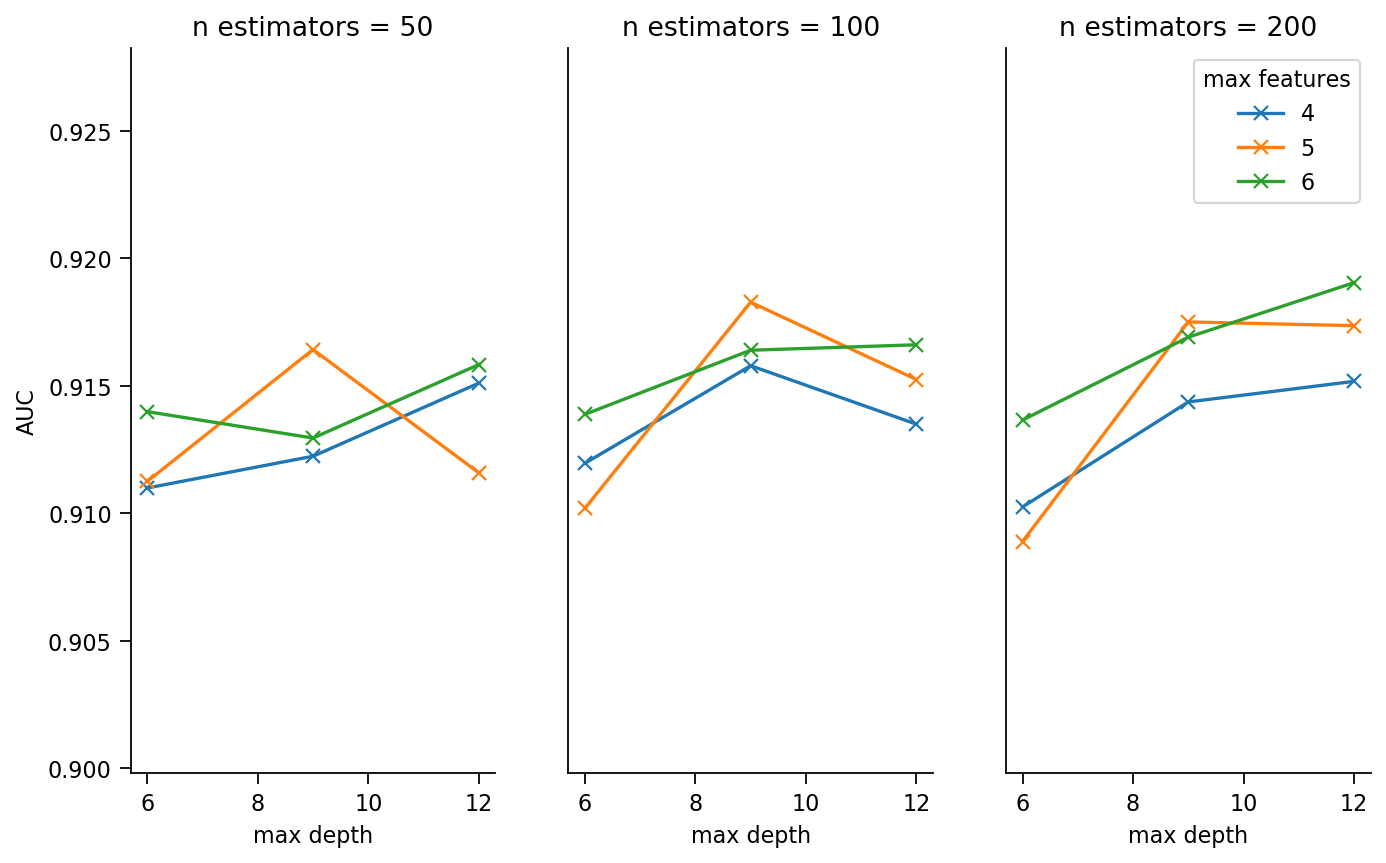

In [93]:
#-----------------------------------------------------------
#
# Visualise CV results
#
#-----------------------------------------------------------

rf_results = pd.DataFrame(grid_search_rf.cv_results_)

rf_plt_cols = ['param_random_forest__n_estimators',
               'param_random_forest__max_features',
               'param_random_forest__max_depth',
               'mean_test_score',
               'std_test_score']

rf_ = rf_results.loc[:, rf_plt_cols]
rf_ = rf_.rename(columns = {'param_random_forest__n_estimators':'n estimators',
                      'param_random_forest__max_depth':'max depth',
                      'param_random_forest__max_features':'max features',
                      'mean_test_score' : 'AUC'})
        
train_plot(rf_, f_size = (10,6));

### Once again, it may be useful to rebuild feature dataset with names to examine attributes of the model

The features will be different, as we made different choices in our data processing steps in the pipeline. Most notably, we didnt allow polynomial features to be generated.

In [94]:
# rebuild features. Notice we selected polynomial terms
# can access parts of the pipeline like so
num_pipe_rf = grid_search_rf.best_estimator_.get_params()['union__num_pipeline']
cat_pipe_rf = grid_search_rf.best_estimator_.get_params()['union__cat_pipeline']

names_1a = num_pipe_rf.get_params()['zero_var'].get_feature_names(np.array(float_cols + int_cols))
names_2a = num_pipe_rf.get_params()['correlation'].get_feature_names(names_1a)
names_3a = num_pipe_rf.get_params()['poly_features'].get_feature_names(names_2a)

names_1b = cat_pipe_rf.get_params()['nulls_col_removal'].get_feature_names(np.array(fac_cols))
names_2b = cat_pipe_rf.get_params()['categorical_encoder'].get_feature_names(names_1b)
names_3b = cat_pipe_rf.get_params()['zero_var'].get_feature_names(names_2b)
names_4b = cat_pipe_rf.get_params()['correlation'].get_feature_names(names_3b)

names_1c = np.array(names_3a + names_4b.tolist())
rf_feature_names = grid_search_rf.best_estimator_.get_params()['correlation'].get_feature_names(names_1c)

In [95]:
# Lets look at feature importance - relates to how many times the
# feature was chosen for a split in the tree

rf_model = grid_search_rf.best_estimator_.get_params()['random_forest']
rf_importance = rf_model.feature_importances_
sorted(list(zip( rf_importance, rf_feature_names )), key = lambda x: x[0], reverse=True)

[(0.26653386090194353, 'account_length'),
 (0.14420314221349845, 'total_intl_calls'),
 (0.10951769165055449, 'total_day_calls'),
 (0.08838045586585389, 'international_plan'),
 (0.0813761961864029, 'total_eve_calls'),
 (0.07899242531941515, 'number_customer_service_calls'),
 (0.04903440477294311, 'voice_mail_plan'),
 (0.045703034078763846, 'total_night_calls'),
 (0.030403682647869183, 'total_eve_charge'),
 (0.028137000433715954, 'total_day_charge'),
 (0.02686174798505782, 'total_intl_charge'),
 (0.024624850346580768, 'total_night_charge'),
 (0.019965372287399204, 'state'),
 (0.006266135310001596, 'area_code')]

# Class imbalance

We saw there was class imbalace- it wasnt too severe (about 85% positive class), but we would be interested to see how sampling affects a model.

Up (or down) sampling is a common approach to address imbalance (Kuhn, Johnson: Applied Predictive Modelling)

This is an interesting problem- all of our pipeline considerations have been acting on __columns__, but now we need to operate on __rows__

We have implemented a factory which makes use of a mixin to alter the behaviour of Scikit Learn model classes. This mixin hijacks the fit method on the model, and performs up/down sampling on rows before the model is fit. We have to override the \_get_param_names class method in the BaseEstimator to allow us to pass keyword arguments into our generated class. __Be careful, we have reversed a design decision by doing this.__

We will demonstrate this by seeing if upsampling the minority class (customer did churn) can improve our model.


In [96]:
# have a look at the code to see how this is implemented!
from sampling import sample_clf_factory

In [97]:
LogisticRegressionWithSampling = sample_clf_factory(LogisticRegression)

lr_upsample_est = copy.deepcopy(prep_pipe)
lr_upsample_est.steps.append(('lr_upsample', LogisticRegressionWithSampling(random_state=1234, solver='liblinear')))

lr_us_param_grid = dict(
    union__num_pipeline__opt_scaler__scale=[True],
    union__num_pipeline__poly_features__degree=[2],
    union__cat_pipeline__categorical_encoder__optional_drop_ix=[opt_drop_col_ix],
    lr_upsample__penalty=['l1'],
    lr_upsample__C=[0.01, 0.1, 1.0],
    lr_upsample__target_ratio=[0.15, 0.25, 0.5, 0.75, 1.0],
    lr_upsample__upsample=[True, False]
)

In [98]:
grid_search_lr_us = GridSearchCV(estimator=lr_upsample_est,
                              param_grid=lr_us_param_grid,
                              scoring='roc_auc',
                              n_jobs=3,
                              cv=5,
                              refit=True,
                              verbose=1)
grid_search_lr_us.fit(features_train, outcome_train);


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/Users/theotsiftis/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   11.0s finished


In [99]:
# GridSearchCV object has many useful attributes, for example:
#
print('Chosen params: {}\n\nTrain AUC score: {:0.3f}'.format(grid_search_lr_us.best_params_,
                                                        grid_search_lr_us.best_score_))

Chosen params: {'lr_upsample__C': 1.0, 'lr_upsample__penalty': 'l1', 'lr_upsample__target_ratio': 0.75, 'lr_upsample__upsample': False, 'union__cat_pipeline__categorical_encoder__optional_drop_ix': [0, 51], 'union__num_pipeline__opt_scaler__scale': True, 'union__num_pipeline__poly_features__degree': 2}

Train AUC score: 0.880


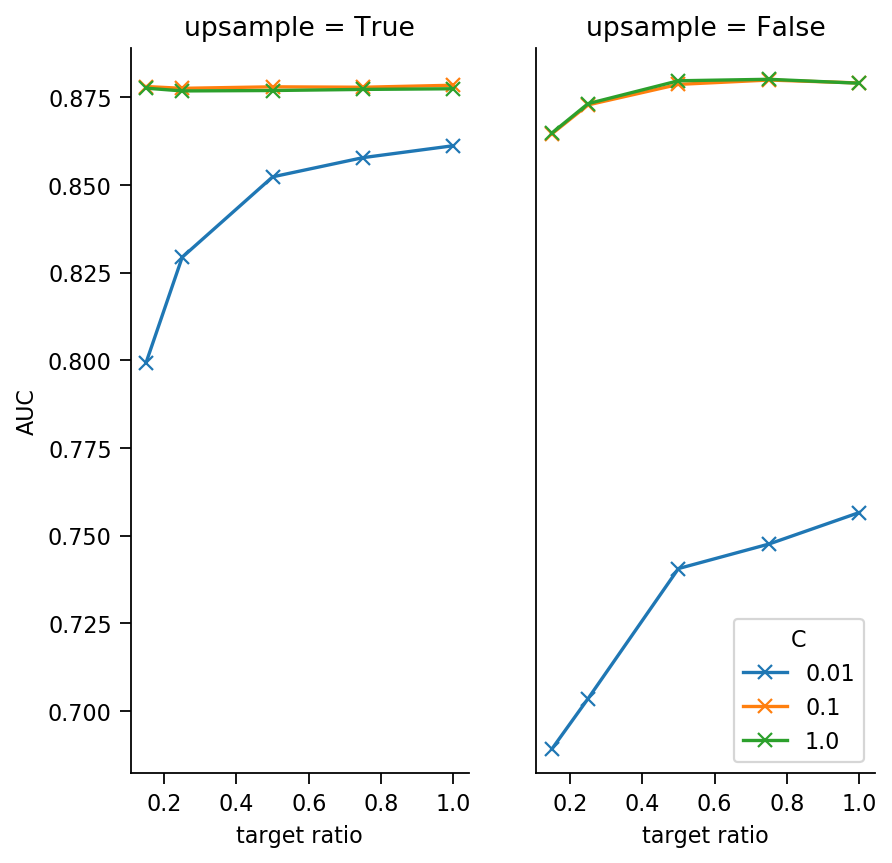

In [100]:
# note: when upsample is false, it means downsample the majority class
# when it is true, we upsample the minority class

lr_us_results = pd.DataFrame(grid_search_lr_us.cv_results_)
plt_cols = ['param_lr_upsample__upsample',
            'param_lr_upsample__C',
            'param_lr_upsample__target_ratio',
            'mean_test_score',
            'std_test_score']

lr_us_results_ = (
    lr_us_results
                 .loc[:, plt_cols]
                 .rename(columns = {'param_lr_upsample__C' : 'C',
                                    'param_lr_upsample__upsample' : 'upsample',
                                    'param_lr_upsample__target_ratio' :'target ratio',
                                    'mean_test_score' : 'AUC'
                                    })
)

train_plot(lr_us_results_);

### Was sampling effective here?

We see no improvement here compared to the best model. However, for small C, the sampling can improve the model significantly.

However, the purpose is to demonstrate _how_ you might implement such a solution to modify the behaviour of a sklearn estimator. This is useful to experiment with- in this case it may not imprvove the quality of the model, but in instances where a more severe class imbalance is present, it may be an essential technique.

# Model evaluation

Time for evaluation on the test set! The main purpose is to demonstrate that we can now feed the test data through the same pipeline using the predict() method. Remember, our pipeline object is wrapped up in a GridSearchCV object. This is really neat- it means we dont have to manually perform the same preprocessing steps on the test data set: the predict method will just apply the best model stored in the object.

We will look at a few perfomance metrics and graphics to interpret the final results as well.

In [101]:
# predictions: 'hard' (i.e. class, based on a 0.5 threshold)
# and probability, i.e. probability positive class
lr_predictions = grid_search_lr.predict(features_test)
lr_prob = grid_search_lr.predict_proba(features_test)[:, 1]

lr_us_predictions = grid_search_lr_us.predict(features_test)
lr_us_prob = grid_search_lr_us.predict_proba(features_test)[:, 1]

rf_predictions = grid_search_rf.predict(features_test)
rf_prob = grid_search_rf.predict_proba(features_test, )[:, 1]

We will consider the ROC curve initially, as we chose it as our metric for cross validation. I chose it as a 'safe' option: it is a useful metric as we get some degree of balance between sensitivity and specificity of the model. A 'perfect' model has an AUC of 1. 

We can plot the curves using the ROCPlot() class, and calculate the AUC with roc_auc_score():

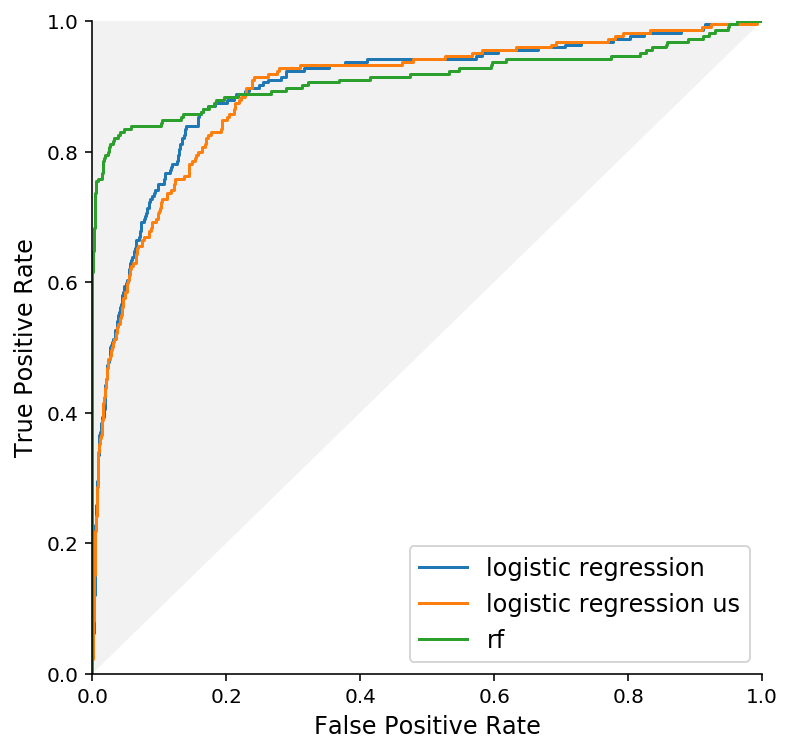

In [102]:
# intialise object
roc = ROCPlot(outcome_test.values) 
# add predictions from models
# roc.calc_roc(rf_prob, 'random forest')
roc.calc_roc(lr_prob, 'logistic regression')
roc.calc_roc(lr_us_prob, 'logistic regression us')
roc.calc_roc(rf_prob, 'rf')


# use buit in helper method for plotting
roc.plot(figsize = (6,6));

In [103]:
print('''
Logistic regression AUC: {:0.3f}
Logistic regression with upsample AUC: {:0.3f}
Random Forest AUC: {:0.3f}
'''.format(roc_auc_score(outcome_test,lr_prob),
           roc_auc_score(outcome_test, lr_us_prob),
           roc_auc_score(outcome_test, rf_prob))
     )


Logistic regression AUC: 0.901
Logistic regression with upsample AUC: 0.896
Random Forest AUC: 0.915



However, it is always useful to consider metrics that are applicable for the model use case. Presumably we would want to reach customers who are at risk of churn. Perhaps give them an offer (at our expense) to stop them churning.

Therefore, to maximise ROI for a campaign like this, we want to only send offers to customers who will truely churn: False positives would not have churned, and we may have sent them an offer for no reason.

A lift chart is a nice approach when considering how you might proactially use the model. We order the preddicted probabilities from highest to lowest, and we consider the percentage of positive events (churns) we find as a function of how many samples we test.

A business decision could be made to reach, say, 75% of customers who will churn. We can then read off our lift chart to see how much of the population we would have to contact to achieve this.

We see that using our logistic regression model, to catch 75% of churners, we have to test about 20% of our customer base. However, for the random forest model, we would only have to test about 10%, which could give us significant savings! We also see that we can get no false positives for up to about 70% of churning customers if we use the random forest model.


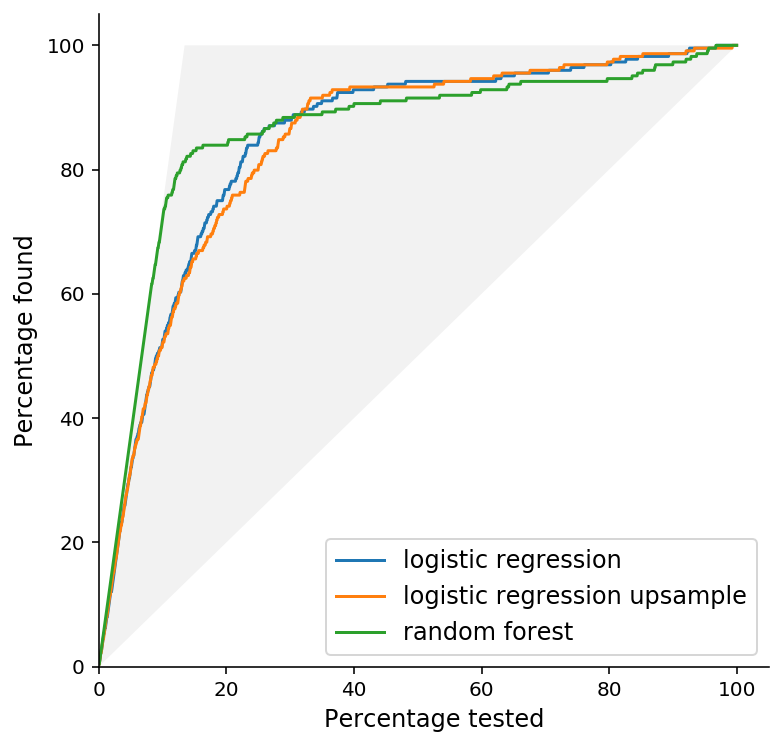

In [104]:
# initialise object
lift = LiftChart(outcome_test.values) 
# add the predictions
lift.calc_uplift(lr_prob, 'logistic regression')
lift.calc_uplift(lr_us_prob, 'logistic regression upsample')
lift.calc_uplift(rf_prob, 'random forest')


# built in helper method for plotting
lift.plot(thresh_pct=None, figsize = (6,6));

# Random Forest with SMOTE 

In [105]:
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

pipe =  Pipeline([
    ('union', FeatureUnion(
        transformer_list = [  
            # pipeline to transform numeric features
            ('num_pipeline', num_pipeline),

            # pipeline for categorical
            ('cat_pipeline', cat_pipeline),
        ],
        #other arguments for FeatureInion        
        n_jobs = 1,transformer_weights = None
    ))])

In [106]:
# use same preperation pipeline, just a different estimator
rf_est_smote = copy.deepcopy(pipe)
rf_est_smote.steps.append(('smote', SMOTE(random_state=42, n_jobs=-1)))
rf_est_smote.steps.append(('random_forest', RandomForestClassifier(random_state = 1234)))
# parameters
# We can set the params to a single value for those hyperparameters we want to fix,
# for example we want to turn off the scaler, dont drop any optional columns,
# and fix poly degree to 1 (i.e. no poly terms)
rf_param_grid_smote = dict(union__num_pipeline__opt_scaler__scale=[False],
                     union__cat_pipeline__categorical_encoder__OneHot = [False],
                     union__cat_pipeline__categorical_encoder__optional_drop_ix = [None],
                     smote__k_neighbors = [5, 10],
                     random_forest__n_estimators = [50, 100, 200],
                     random_forest__max_depth = [6, 9, 12],
                     random_forest__max_features = [4, 5, 6])
                    
grid_search_rf_smote = GridSearchCV(estimator=rf_est_smote,
                              param_grid=rf_param_grid_smote,
                              scoring='roc_auc',
                              n_jobs=3,
                              cv=5,
                              refit=True,
                              verbose=1)

grid_search_rf_smote.fit(features_train, outcome_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/Users/theotsiftis/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   12.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 270 out of 270 | elapsed:  2.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(n_jobs=1,
                                                     transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['total_day_minutes',
                                                                                                                            'total_day_charge',
                                                                                                                            'total_eve_minutes',
                                                                                                                            'total_eve_charge',
                                                                                                      

In [107]:
print('Chosen params: {}\n\nTrain AUC score: {:0.3f}'.format(grid_search_rf_smote.best_params_,
                                                        grid_search_rf_smote.best_score_))

Chosen params: {'random_forest__max_depth': 12, 'random_forest__max_features': 6, 'random_forest__n_estimators': 100, 'smote__k_neighbors': 5, 'union__cat_pipeline__categorical_encoder__OneHot': False, 'union__cat_pipeline__categorical_encoder__optional_drop_ix': None, 'union__num_pipeline__opt_scaler__scale': False}

Train AUC score: 0.911


## Random Forest with SMOTE:  Model Evaluation


In [108]:
# and probability, i.e. probability positive class
lr_predictions = grid_search_lr.predict(features_test)
lr_prob = grid_search_lr.predict_proba(features_test)[:, 1]

rf_predictions = grid_search_rf.predict(features_test)
rf_prob = grid_search_rf.predict_proba(features_test, )[:, 1]

rf_smote_predictions = grid_search_rf_smote.predict(features_test)
rf_smote_prob = grid_search_rf_smote.predict_proba(features_test, )[:, 1]

print(round(roc_auc_score(outcome_test, rf_smote_predictions), 2))

0.88


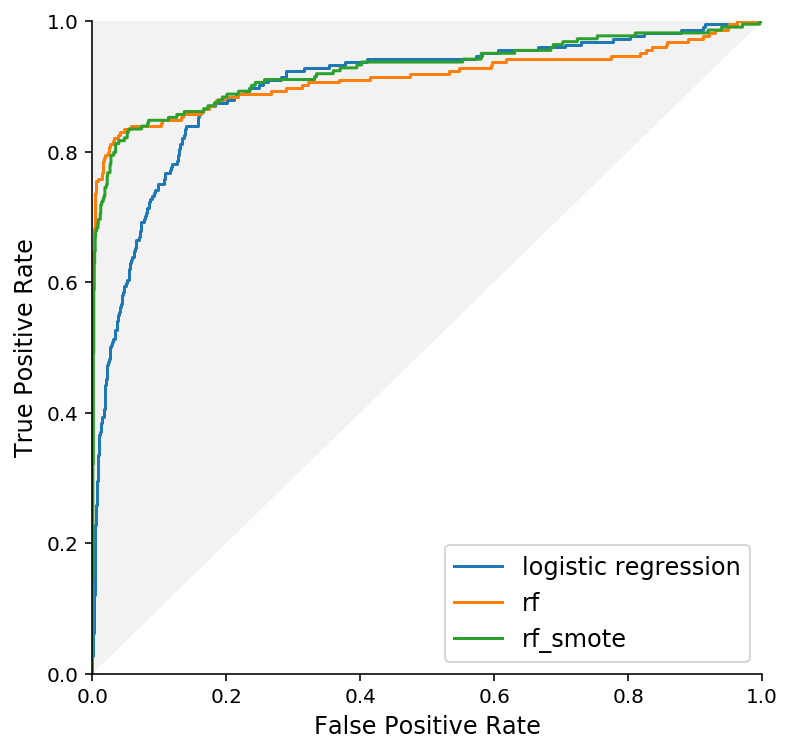

In [109]:
# intialise object
roc = ROCPlot(outcome_test.values) 
# add predictions from models
# roc.calc_roc(rf_prob, 'random forest')
roc.calc_roc(lr_prob, 'logistic regression')
roc.calc_roc(rf_prob, 'rf')
roc.calc_roc(rf_smote_prob, 'rf_smote')


# use buit in helper method for plotting
roc.plot(figsize = (6,6));

## Random Forest with SMOTE Changing the threshold: find the optimal 

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

false_pos_rate, true_pos_rate, proba = roc_curve(outcome_test, rf_smote_prob)

optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), 
                              key=lambda i: i[0], reverse=True)[0][1]
roc_predictions_opt_cutoff = [1 if i >= optimal_proba_cutoff else 0 for i in rf_smote_prob]

print(round(optimal_proba_cutoff, 2))
print(round(roc_auc_score(outcome_test, roc_predictions_opt_cutoff), 2))

0.4
0.89


# Summary

Overall, we have demonstrated how to use sklearn pipelines to process data and fit learning algorithms, selecting the best combination of preprocessing and model parameters. We focussed on the Pipeline, FeatureUnion and GridSearchCV classes. We have also investigated some techniques for evaluating the results of our churn model.